In [1]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets # datasets 추가
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm

# GPU 확인 코드 (추가)
print("="*50)
print("GPU 호환성 체크")
print("="*50)
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
print(f"CUDA 버전: {torch.version.cuda}")
print(f"GPU 개수: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"메모리: {torch.cuda.get_device_properties(i).total_memory // 1024**2} MB")
else:
    print("GPU를 사용할 수 없습니다. CPU 모드로 실행됩니다.")

print(f"현재 디바이스: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
print("="*50)

GPU 호환성 체크
PyTorch 버전: 2.8.0+cu129
CUDA 사용 가능: True
CUDA 버전: 12.9
GPU 개수: 1
GPU 0: NVIDIA GeForce RTX 4070 Ti
메모리: 12281 MB
현재 디바이스: cuda


In [2]:
# ==============================================================
# 1. 경로 및 전처리 설정
# ==============================================================

# 데이터셋 루트 경로 설정
data_dir = "C:/blooming_AI/classification_dataset" # 예시 경로입니다. 실제 'dataset' 폴더의 상위 경로로 지정해주세요.
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# torchvision.datasets.ImageFolder를 사용하여 데이터셋 생성
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 클래스 이름은 ImageFolder가 자동으로 폴더명에서 가져옵니다.
class_names = train_dataset.classes
print(f"클래스 발견: {class_names}")
print(f"클래스-인덱스 매핑: {train_dataset.class_to_idx}")

클래스 발견: ['downy', 'healthy', 'powdery']
클래스-인덱스 매핑: {'downy': 0, 'healthy': 1, 'powdery': 2}


In [3]:
# ==============================================================
# 2. 모델 정의
# ==============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(pretrained=True)
# 출력층의 뉴런 개수를 데이터셋의 클래스 개수에 맞춰 자동으로 설정
model.classifier[1] = nn.Linear(model.last_channel, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

C:\Users\51100\anaconda3\envs\ultra\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\51100\anaconda3\envs\ultra\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# ======================
# 3. Training Loop
# ======================
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    # --- Train ---
    model.train()
    running_loss, running_corrects = 0.0, 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # --- Validation ---
    model.eval()
    val_running_loss, val_running_corrects = 0.0, 0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val  ]")
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)

    val_loss = val_running_loss / len(val_dataset)
    val_acc = val_running_corrects.double() / len(val_dataset)
    end_time = time.time()
    epoch_duration = end_time - start_time
    minutes = int(epoch_duration // 60)
    seconds = int(epoch_duration % 60)
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | "
          f"Time: {minutes}m {seconds}s")
    # best 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_mobilenet_cucumber.pth")

print("Training finished. Best Val Acc:", best_val_acc.item())

Epoch 1/10 [Val  ]: 100%|████████████████████████████████████████████████████████████| 178/178 [10:22<00:00,  3.50s/it]


Epoch 1/10 | Train Loss: 0.0377, Acc: 0.9887 | Val Loss: 0.0035, Acc: 0.9995
Epoch 1/10 | Train Loss: 0.0377, Acc: 0.9887 | Val Loss: 0.0035, Acc: 0.9995 | Time: 59m 50s


Epoch 2/10 [Val  ]: 100%|████████████████████████████████████████████████████████████| 178/178 [09:48<00:00,  3.31s/it]


Epoch 2/10 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0036, Acc: 0.9989
Epoch 2/10 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0036, Acc: 0.9989 | Time: 60m 57s


Epoch 3/10 [Val  ]: 100%|████████████████████████████████████████████████████████████| 178/178 [09:55<00:00,  3.35s/it]


Epoch 3/10 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.0006, Acc: 1.0000
Epoch 3/10 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.0006, Acc: 1.0000 | Time: 61m 20s


Epoch 4/10 [Val  ]: 100%|████████████████████████████████████████████████████████████| 178/178 [09:37<00:00,  3.24s/it]


Epoch 4/10 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0011, Acc: 0.9996
Epoch 4/10 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0011, Acc: 0.9996 | Time: 60m 57s


Epoch 5/10 [Val  ]: 100%|████████████████████████████████████████████████████████████| 178/178 [09:48<00:00,  3.30s/it]


Epoch 5/10 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0012, Acc: 0.9998
Epoch 5/10 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0012, Acc: 0.9998 | Time: 60m 16s


Epoch 6/10 [Val  ]: 100%|████████████████████████████████████████████████████████████| 178/178 [09:51<00:00,  3.32s/it]


Epoch 6/10 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0001, Acc: 1.0000
Epoch 6/10 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0001, Acc: 1.0000 | Time: 60m 55s


Epoch 7/10 [Val  ]: 100%|████████████████████████████████████████████████████████████| 178/178 [09:41<00:00,  3.27s/it]


Epoch 7/10 | Train Loss: 0.0079, Acc: 0.9981 | Val Loss: 0.0007, Acc: 0.9998
Epoch 7/10 | Train Loss: 0.0079, Acc: 0.9981 | Val Loss: 0.0007, Acc: 0.9998 | Time: 60m 42s


Epoch 8/10 [Val  ]: 100%|████████████████████████████████████████████████████████████| 178/178 [09:46<00:00,  3.30s/it]


Epoch 8/10 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0009, Acc: 0.9998
Epoch 8/10 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0009, Acc: 0.9998 | Time: 60m 21s


Epoch 9/10 [Val  ]: 100%|████████████████████████████████████████████████████████████| 178/178 [09:46<00:00,  3.29s/it]


Epoch 9/10 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0075, Acc: 0.9966
Epoch 9/10 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0075, Acc: 0.9966 | Time: 60m 33s


Epoch 10/10 [Val  ]: 100%|███████████████████████████████████████████████████████████| 178/178 [09:48<00:00,  3.31s/it]

Epoch 10/10 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0012, Acc: 0.9996
Epoch 10/10 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0012, Acc: 0.9996 | Time: 60m 38s
Training finished. Best Val Acc: 0.9999999999999999



=== Final Evaluation on Test Set ===


Testing on CPU: 100%|████████████████████████████████████████████████████████████████| 178/178 [10:25<00:00,  3.52s/it]


Total test images: 5666
Average inference time per image (CPU): 8.5506 ms

Classification Report:
              precision    recall  f1-score   support

       downy     0.9987    1.0000    0.9994      1557
     healthy     1.0000    0.9990    0.9995      2019
     powdery     1.0000    1.0000    1.0000      2090

    accuracy                         0.9996      5666
   macro avg     0.9996    0.9997    0.9996      5666
weighted avg     0.9996    0.9996    0.9996      5666

Confusion Matrix:
 [[1557    0    0]
 [   2 2017    0]
 [   0    0 2090]]


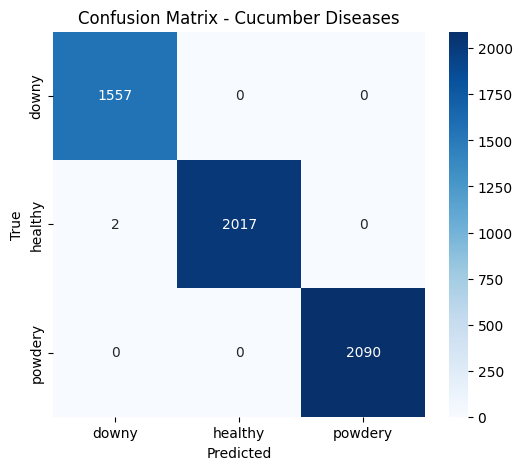

In [7]:
# ======================
# 6. 최종 평가 (Test Set)
# ======================
print("\n=== Final Evaluation on Test Set ===")
eval_device = torch.device("cpu")
model.load_state_dict(torch.load("best_mobilenet_cucumber.pth", map_location=eval_device))
model.to(eval_device)
model.eval()

all_preds = []
all_labels = []

total_inference_time = 0.0
total_images = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing on CPU"):
        # --- 💡 3. 데이터도 CPU로 이동 💡 ---
        inputs, labels = inputs.to(eval_device), labels.to(eval_device)

        # 시간 측정 시작
        start_time = time.time()
        outputs = model(inputs) # 모델 추론
        end_time = time.time() # 시간 측정 종료

        total_inference_time += (end_time - start_time)
        total_images += inputs.size(0)

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 평균 추론 시간 계산 및 출력
avg_inference_time_ms = (total_inference_time / total_images) * 1000
print(f"\nTotal test images: {total_images}")
print(f"Average inference time per image (CPU): {avg_inference_time_ms:.4f} ms")


print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# ======================
# 7. Confusion Matrix 시각화
# ======================
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Cucumber Diseases")
plt.show()